### Reconhecimento de emoções.

O principal objetivo desse notebook é fazer um treinando de uma rede neural que consiga detectar emoções em tempo real usando imagem de uma camera (Webcam para começar).

Para isso usaremos o dataset FER2013 (Facial Expression Recognition), disponível para download [aqui](https://www.kaggle.com/msambare/fer2013).

Iremos explicar todo o passo a passo, desde o processamento inicial das imagens, até o final do treinamento das redes neurais onde salvaremos alguns modelos para criar um API que ficará disponível para teste do público.


### Processamento das imagens e criação de um arquivo CSV.

O Dataset FER2013 está dividido em pastas, uma de treinamento e outra de teste, cada uma dessas pastas tem sete categorias de expressões, são elas:

 - 0: Zangado
 - 1: Nojo 
 - 2: Medo 
 - 3: Feliz
 - 4: Natural
 - 5: Triste
 - 6: Surpresa

A melhor maneira de trabalhar com essas imagens em uma rede neural é utilizando a função de pré-processamento "ImageDataGenerator" do Keras.

Vamos fazer isso para separar os dados de treino e de teste.

In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime
import keras
import tensorflow as tf
from keras import regularizers
from keras.models import Sequential, load_model
from keras.utils.vis_utils import plot_model
from keras.layers import Conv2D, MaxPool2D, MaxPooling2D, Flatten,Dense,Dropout,BatchNormalization, GlobalAveragePooling2D
from keras.callbacks import CSVLogger, TensorBoard, EarlyStopping
from tensorflow.keras.optimizers import Adam,RMSprop,SGD,Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [5]:
# diretorios de treino e teste

dir_treino = "imagens/train"
dir_teste = "imagens/test"

In [3]:
# criando os dataset de treino e teste

gerar_datatreino = ImageDataGenerator()
gerar_datateste = ImageDataGenerator()

Xtreino = gerar_datatreino.flow_from_directory(directory=dir_treino, 
                                                      target_size=(48,48),
                                                      batch_size= 70, color_mode = 'grayscale',
                                                      class_mode='categorical')

Xteste = gerar_datateste.flow_from_directory(directory=dir_teste, 
                                                      target_size=(48,48),
                                                      batch_size= 64, color_mode = 'grayscale',
                                                      class_mode='categorical')

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


In [10]:
# dicionário com os significados de cada classe

dict_emocoes = {
    0: "Zangado", 
    1: "Nojo", 
    2: "Medo", 
    3: "Feliz",
    4: "Natural", 
    5: "Triste", 
    6: "Surpresa"
}

Temos nossos dados separados, porém eles estão em formatos de um dataset do keras, cada elemento do Xtreino é um batch com 70 imagens do dataset de treino, então vamos usar algumas funções do tensorflow para conseguir visualizar essas imagens nesse dataset.

[Documentação - tf.data.Dataset](https://www.tensorflow.org/api_docs/python/tf/data/Dataset)

In [ ]:
type(Xtreino)

tensorflow.python.keras.preprocessing.image.DirectoryIterator

In [ ]:
# pegando o primeiro batch para visualizar as suas imagens

datasetTreino = tf.data.Dataset.from_tensor_slices(Xtreino[1])
listaTreino = list(datasetTreino.as_numpy_iterator())

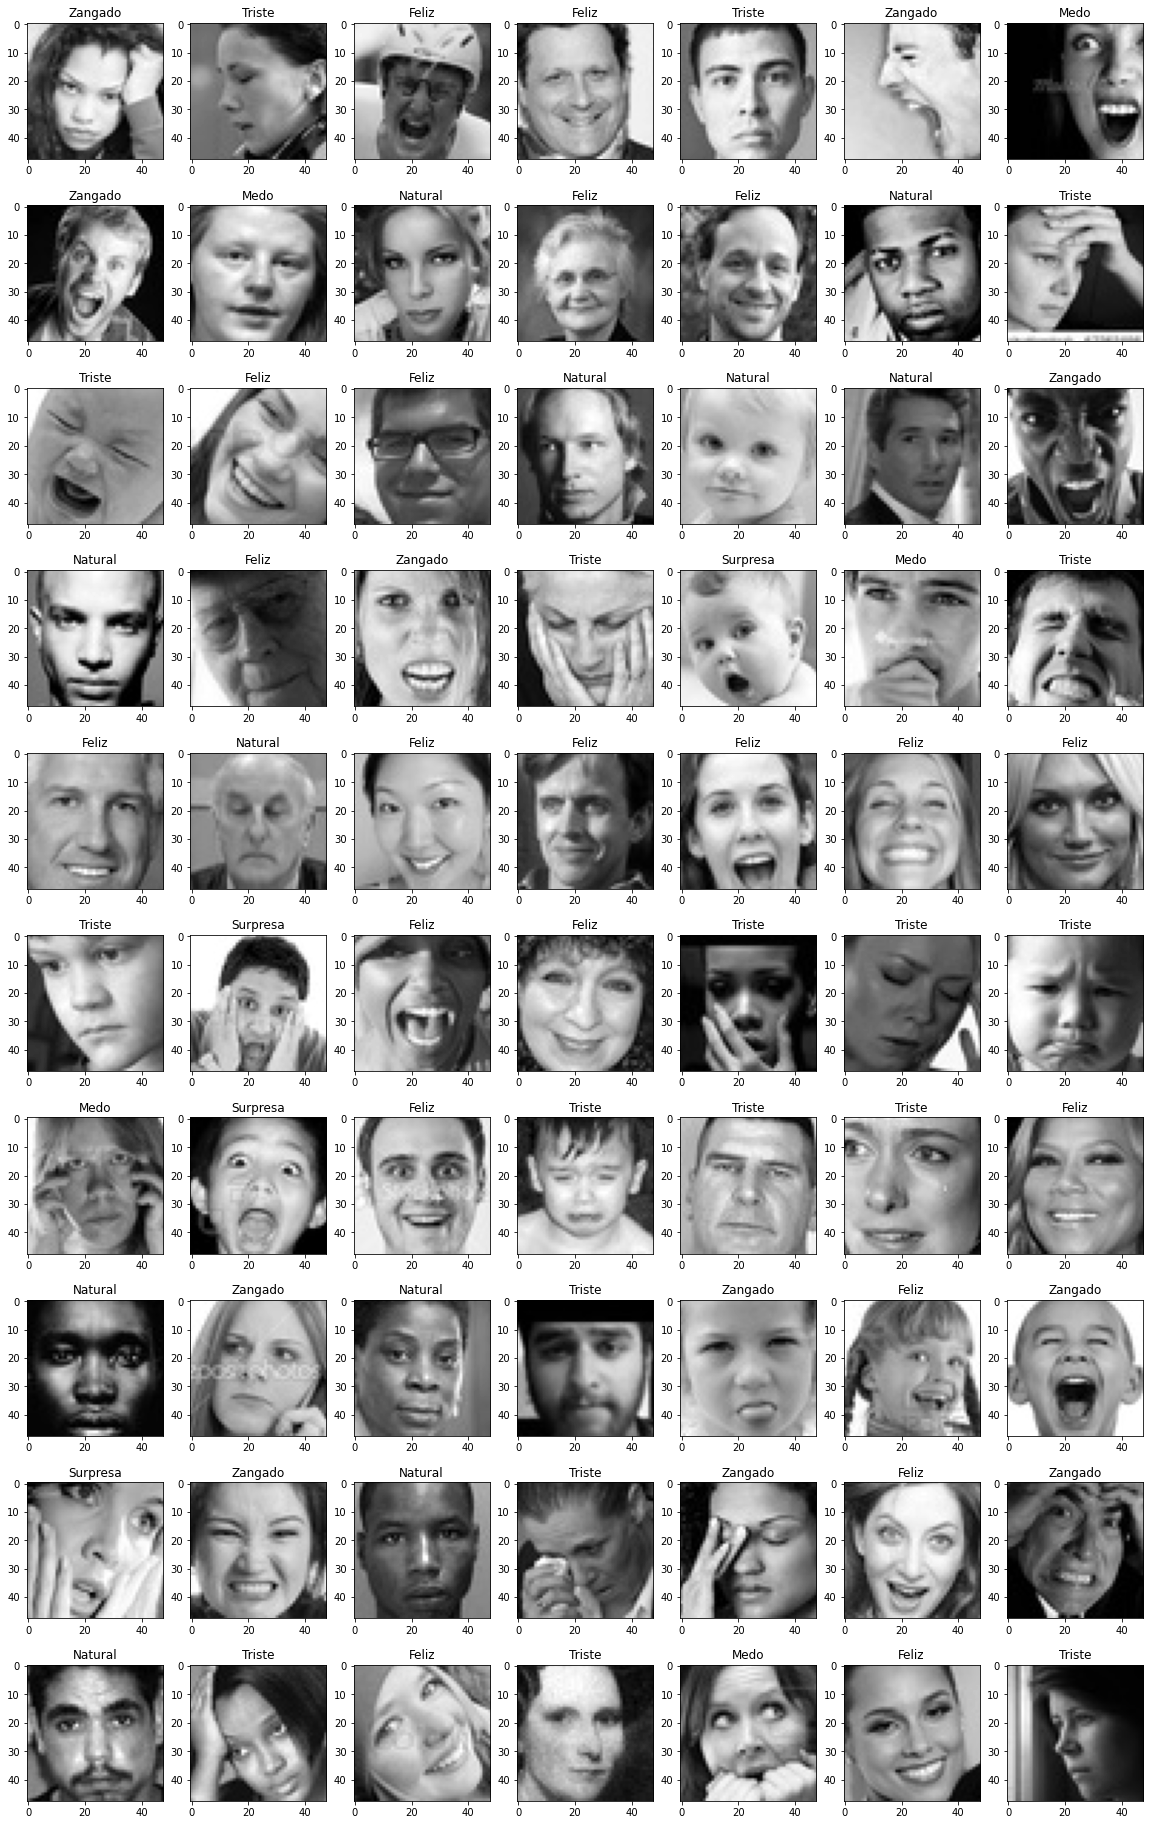

In [ ]:
# visualizando algumas imagens

plt.figure(figsize=(20,33))
for n in range(len(listaTreino)):
    plt.subplot(10,7,n+1)
    plt.imshow(listaTreino[n][0],cmap='gray')
    plt.title(dict_emocoes[np.argmax(listaTreino[n][1])])
plt.show()

### Criando arquivo .CSV

Pode ser interessante criar um arquivo .csv dessas imagens, assim podemos ter um recurso a mais para trabalhar, também podemos com esse aquivo agrupar as imagens para fazer uma contagem de quantas fotos de cada categoria temos.

O código abaixo cria um arquivo csv de todas as imagens armazenadas no dataset Xtreino.

In [ ]:
listaTreino1 = []
for item in listaTreino:
    item1 = dict_emocoes[np.argmax(item[1])]
    listaTreino1.append([item[0],item1])

array = np.array(listaTreino1, dtype=object)
df_emotions = pd.DataFrame(array, columns = ['pixels', 'categoria'])

for n in range(1,len(Xtreino)):
    datasetTreino = tf.data.Dataset.from_tensor_slices(Xtreino[n])
    listaTreino = list(datasetTreino.as_numpy_iterator())
    listaTreino2 = []
    for item in listaTreino:
        item1 = dict_emocoes[np.argmax(item[1])]
        listaTreino2.append([item[0],item1])
    array1 = np.array(listaTreino2, dtype=object)
    df_emotions1 = pd.DataFrame(array1, columns = ['pixels', 'categoria'])
    df_emotions = pd.concat([df_emotions, df_emotions1])

In [ ]:
# conferindo o tamanho

df_emotions.shape

(28709, 2)

In [ ]:
df_emotions.head()

pixels categoria
0  [[[221.0], [214.0], [220.0], [215.0], [215.0],...   Zangado
1  [[[94.0], [92.0], [91.0], [92.0], [93.0], [93....    Triste
2  [[[232.0], [235.0], [239.0], [242.0], [242.0],...     Feliz
3  [[[56.0], [47.0], [40.0], [32.0], [46.0], [59....     Feliz
4  [[[95.0], [94.0], [98.0], [99.0], [95.0], [106...    Triste

In [ ]:
# contando quantas imagens temos em cada categoria

df_count = df_emotions.categoria.value_counts().reset_index().rename(columns={
                                                                    'index': 'Emoção', 
                                                                    'categoria': 'Quantidade'
                                                                    })

df_count

Emoção  Quantidade
0     Feliz        7219
1   Natural        4964
2    Triste        4840
3      Medo        4088
4   Zangado        4002
5  Surpresa        3163
6      Nojo         433

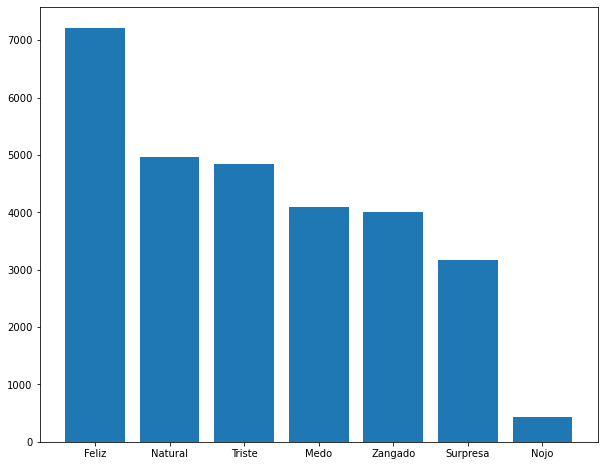

In [ ]:
# plotando um gráfico

plt.figure(figsize=(10,8))
plt.bar(df_count['Emoção'],df_count['Quantidade'])
plt.show()

In [ ]:
# criando um arquivo em csv com as imagens já em formato de mátrizes

df_emotions.to_csv('datasets/emotions.csv')

Pronto, concluimos a criação do nosso arquivo csv com as imagens já em forma de matriz e com cada categoria dela.

### Criando uma classe para todo o processo.

Todo esse processo feito acima pode ser util em outras situações futuras, vamos criar então uma classe, onde juntamos todo esse processamento em um único lugar, assim não precisaremos ficar repetindo sempre, quando precisar trabalhar com outro conjunto de imagens.

In [ ]:
class ProcessamentoImagensCategorias():
    '''
    Classe para processar imagens organizadas em pastas separas por categórias. 
    '''

    def __init__(self, dir_treino, dir_teste, 
                 shape, cores = 3, dici = None):
        '''
        dir_treino: diretório da pasta de treino
        dir_teste: diretório da paste de teste
        shape: dimensão das imagens dos diretório, exemplo (48,48)
        cores: cor da imagem, 1 para preto e branco, 3 para RGB e 4 para RBA.
        '''
    
        self.dir_treino = dir_treino
        self.dir_teste = dir_teste
        self.shape = shape
        self.cores = cores
        self.dici = dici
        
    def gerar_datasets(self, batch = 32):
        '''
        Gera dois datasets do Keras divididos em treino e teste agrupados pelo tamanho do Batchsize escolhido
        
        batch: Batchsize escolhido para o agrupamento nos dados de treino e teste.
        '''
        self.batch = batch
        gerar_datatreino = ImageDataGenerator()
        gerar_datateste = ImageDataGenerator()
        
        if self.cores == 1:
            self.Xtreino = gerar_datatreino.flow_from_directory(directory=dir_treino, 
                                                              target_size=self.shape,
                                                              batch_size= self.batch, color_mode = 'grayscale',
                                                              class_mode='categorical')
            self.Xteste = gerar_datateste.flow_from_directory(directory=dir_teste, 
                                                      target_size=self.shape,
                                                      batch_size= self.batch, color_mode = 'grayscale',
                                                      class_mode='categorical')
        elif self.cores == 3:
            self.Xtreino = gerar_datatreino.flow_from_directory(directory=dir_treino, 
                                                              target_size=self.shape,
                                                              batch_size= self.batch, color_mode = 'rgb',
                                                              class_mode='categorical')
            self.Xteste = gerar_datateste.flow_from_directory(directory=dir_teste, 
                                                      target_size=self.shape,
                                                      batch_size= self.batch, color_mode = 'rgb',
                                                      class_mode='categorical')
        elif self.cores == 4:
            self.Xtreino = gerar_datatreino.flow_from_directory(directory=dir_treino, 
                                                              target_size=self.shape,
                                                              batch_size= self.batch, color_mode = 'rgba',
                                                              class_mode='categorical')
            self.Xteste = gerar_datateste.flow_from_directory(directory=dir_teste, 
                                                      target_size=self.shape,
                                                      batch_size= self.batch, color_mode = 'rgba',
                                                      class_mode='categorical')
        else:
            print("O parametro 'Cores' escolhido na criação do objeto precisa ser 1, 3 ou 4")
                  
    def plotar_batch(self, n):
        '''
        Plota imagens do n-esimo batch escolhido 
        '''
        try:
            if self.dici == None:
                datasetTreino = tf.data.Dataset.from_tensor_slices(self.Xtreino[n])
                listaTreino = list(datasetTreino.as_numpy_iterator())
                plt.figure(figsize=(20, int(self.batch/2)))
                for n1 in range(len(listaTreino)):
                    plt.subplot(int(self.batch/7)+1,7,n1+1)
                    plt.imshow(listaTreino[n1][0],cmap='gray')
                    plt.title(np.argmax(listaTreino[n1][1]))
                plt.show()
            else:
                datasetTreino = tf.data.Dataset.from_tensor_slices(self.Xtreino[n])
                listaTreino = list(datasetTreino.as_numpy_iterator())
                plt.figure(figsize=(20, int(self.batch/2)))
                for n1 in range(len(listaTreino)):
                    plt.subplot(int(self.batch/7)+1,7,n1+1)
                    plt.imshow(listaTreino[n1][0],cmap='gray')
                    plt.title(self.dici[np.argmax(listaTreino[n1][1])])
                plt.show()
        except:         
            print('Você precisa escolher um n entre 0 e ', len(self.Xtreino)-1)
    def criar_csv_e_dataframe_pandas(self, nome_arquivo):
        '''
        Cria um dataset pandas e um arquivo nome_arquivo.csv com as imagens em formato de matriz e \
        com as categorias especificas de cada.
        
        Além disso cria um dataset com a contagem de todos os elementos agrupados pelas categorias.
        
        dici: Dicionário onde as chaves são as categorias e os valores, os nomes das categorias.
        
        Exemplo, caso o dataset seja um de imagens apenas de gatos e cachorro, crie um dicionário da forma: 
        
        dicionario = {
                0: 'gato'
                1: 'cachorro'
            }
        
        E adicione esse dicionario como parâmetro na variavél dici
        
        Caso o dicionário não seja colocado, a coluna de categorias vira com os valores categóricos de cada uma delas
        '''
        
        self.nome = nome_arquivo
        listaTreino1 = []
        if self.dici == None:
            for item in listaTreino:
                item1 = np.argmax(item[1])
                listaTreino1.append([item[0],item1])

            array = np.array(listaTreino1, dtype = object)
            df_final = pd.DataFrame(array, columns = ['pixels', 'categoria'])

            for n in range(1,len(Xtreino)):
                datasetTreino = tf.data.Dataset.from_tensor_slices(Xtreino[n])
                self.listaTreino = list(datasetTreino.as_numpy_iterator())
                listaTreino2 = []
                for item in self.listaTreino:
                    item1 = np.argmax(item[1])
                    listaTreino2.append([item[0],item1])
                array1 = np.array(listaTreino2, dtype = object)
                df_final1 = pd.DataFrame(array1, columns = ['pixels', 'categoria'])
                df_final = pd.concat([df_final, df_final1])
            self.df_final = df_final
            self.df_contagem = df_count = self.df_final.categoria.value_counts().reset_index().rename(columns={
                                                                    'index': 'Categorias', 
                                                                    'categoria': 'Quantidade'
                                                                    })
            self.df_final.to_csv(self.nome+'.csv')
            print(f"Arquivo {self.nome}.csv criado, utilize os atributos .df_final e .df_contagem para acessar os \
            datasets em formato de pandas e o Dataset com a contagem dos elementos de cada categoria")
        
        else: 
            for item in listaTreino:
                item1 = self.dici[np.argmax(item[1])]
                listaTreino1.append([item[0],item1])

            array = np.array(listaTreino1, dtype=object)
            df_final = pd.DataFrame(array, columns = ['pixels', 'categoria'])

            for n in range(1,len(Xtreino)):
                datasetTreino = tf.data.Dataset.from_tensor_slices(Xtreino[n])
                self.listaTreino = list(datasetTreino.as_numpy_iterator())
                listaTreino2 = []
                for item in self.listaTreino:
                    item1 = self.dici[np.argmax(item[1])]
                    listaTreino2.append([item[0],item1])
                array1 = np.array(listaTreino2, dtype = object)
                df_final1 = pd.DataFrame(array1, columns = ['pixels', 'categoria'])
                df_final = pd.concat([df_final, df_final1])
            self.df_final = df_final
            self.df_contagem = df_count = self.df_final.categoria.value_counts().reset_index().rename(columns={
                                                                    'index': 'Categorias', 
                                                                    'categoria': 'Quantidade'
                                                                    })
            self.df_final.to_csv(self.nome+'.csv')
            print(f"Arquivo {self.nome}.csv criado, utilize os atributos .df_final e .df_contagem para acessar os datasets em formato de pandas e o Dataset com a contagem dos elementos de cada categoria")

### Testando a classe criada

Vamos testar a classe criada no nosso conjunto de imagens

In [ ]:
emocoes = ProcessamentoImagensCategorias(dir_treino, dir_teste, (48,48), 1, dict_emocoes)

In [ ]:
emocoes.gerar_datasets(batch = 70)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


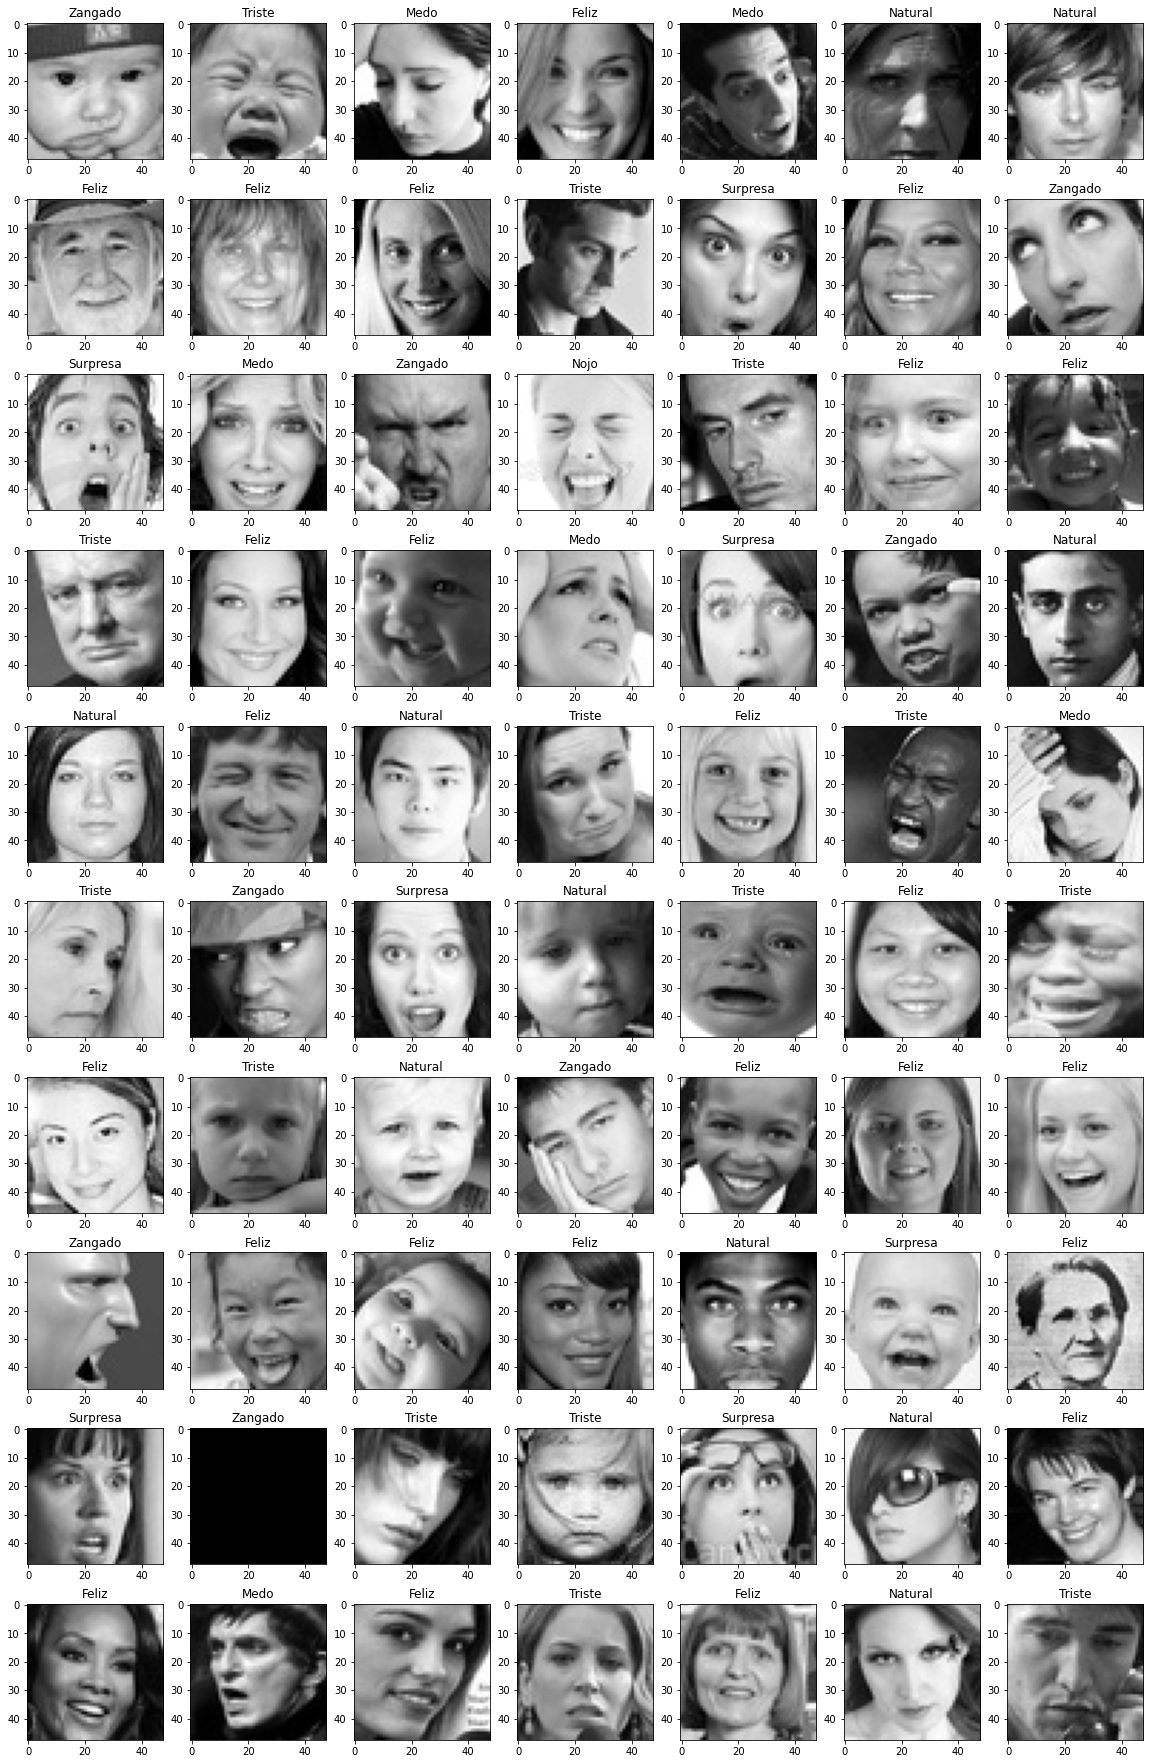

In [ ]:
emocoes.plotar_batch(100)

In [ ]:
emocoes.criar_csv_e_dataframe_pandas('emocoes')

Arquivo emocoes.csv criado, utilize os atributos .df_final e .df_contagem para acessar os datasets em formato de pandas e o Dataset com a contagem dos elementos de cada categoria


In [ ]:
emocoes.df_final.head()

pixels categoria
0  [[[126.0], [120.0], [127.0], [143.0], [131.0],...     Feliz
1  [[[49.0], [40.0], [19.0], [1.0], [0.0], [16.0]...     Feliz
2  [[[97.0], [98.0], [99.0], [99.0], [98.0], [97....   Natural
3  [[[39.0], [41.0], [44.0], [45.0], [44.0], [42....      Nojo
4  [[[200.0], [200.0], [198.0], [196.0], [194.0],...      Medo

In [ ]:
emocoes.df_contagem

Categorias  Quantidade
0      Feliz        7201
1    Natural        4955
2     Triste        4823
3       Medo        4085
4    Zangado        3991
5   Surpresa        3159
6       Nojo         434

Pronto, agora com a classe criada, podemos usa-la sempre que precisarmos trabalhar com imagens que estão salvas em pastas separadas por categorias, o que pode facilitar muito nosso trabalho, essa classe vai ser acrescentada na pasta no arquivo bliblioteca1.py

# Criando e treinando as redes neurais.

Vamos começar a criar nossas reudes neurais, começamos com uma rede mais simples, com poucas camadas e poucos neurônios, sem nenhuma regularização.

In [ ]:
model_simples= Sequential()
model_simples.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', 
                 input_shape=(48, 48,1)))
model_simples.add(BatchNormalization())
model_simples.add(MaxPool2D(pool_size=(2, 2)))
model_simples.add(Dropout(0.2))
model_simples.add(Flatten()) 
model_simples.add(Dense(7,activation = 'softmax'))

model_simples.compile(optimizer = 'Adam', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy']
                      )

In [ ]:
model_simples.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 32)        320       
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 32)        128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 18432)             0         
_________________________________________________________________
dense (Dense)                (None, 7)                 129031    
Total params: 129,479
Trainable params: 129,415
Non-trainable params: 64
_________________________________________________

In [ ]:
%load_ext tensorboard
log_dir = "logs/fit/" + (datetime.datetime.now() + datetime.timedelta(hours=-3)).strftime("%Y%m%d-%H%M%S")

tensorboard_callback = TensorBoard(log_dir=log_dir)
stopper = EarlyStopping(monitor="val_accuracy",
                         patience=10, verbose=2, mode ='max')

callbacks = [tensorboard_callback, stopper]

In [ ]:
steps_per_epoch = Xtreino.n // Xtreino.batch_size
validation_steps = Xteste.n // Xteste.batch_size

history = model_simples.fit(x=Xtreino,
                            validation_data=Xteste,
                            epochs=70,
                            callbacks=callbacks,
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=validation_steps,
                            verbose = 1)

Epoch 1/70
410/410 [==============================] - 86s 152ms/step - loss: 2.7581 - accuracy: 0.2980 - val_loss: 1.8450 - val_accuracy: 0.3867
Epoch 2/70
410/410 [==============================] - 58s 142ms/step - loss: 1.7178 - accuracy: 0.4166 - val_loss: 1.9050 - val_accuracy: 0.3968
Epoch 3/70
410/410 [==============================] - 59s 145ms/step - loss: 1.3890 - accuracy: 0.4936 - val_loss: 1.6926 - val_accuracy: 0.4272
Epoch 4/70
410/410 [==============================] - 56s 136ms/step - loss: 1.2388 - accuracy: 0.5380 - val_loss: 1.6505 - val_accuracy: 0.4322
Epoch 5/70
410/410 [==============================] - 52s 128ms/step - loss: 1.1355 - accuracy: 0.5796 - val_loss: 1.7067 - val_accuracy: 0.4268
Epoch 6/70
410/410 [==============================] - 56s 137ms/step - loss: 1.1005 - accuracy: 0.5880 - val_loss: 1.7513 - val_accuracy: 0.4272
Epoch 7/70
410/410 [==============================] - 54s 132ms/step - loss: 1.0553 - accuracy: 0.6076 - val_loss: 1.7567 - val_ac

In [ ]:
# salvando o modelo

model_simples.save('modelos/primeiro_modelo.h5')

In [ ]:
#carregando o modelo

modelo_simples = load_model('modelos/primeiro_modelo.h5')

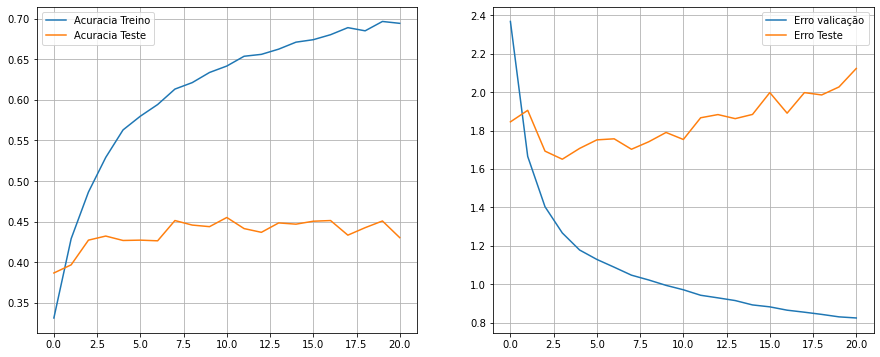

In [ ]:
# graficamente

plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.plot(history.history['accuracy'], label='Acuracia Treino')
plt.plot(history.history['val_accuracy'], label='Acuracia Teste')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history.history['loss'], label='Erro valicação')
plt.plot(history.history['val_loss'], label='Erro Teste')
plt.legend()
plt.grid()



plt.show()

Não conseguimos um bom resultado na nossa primeira rede neural, o que era de se esperar, pois estamos criamos uma rede bem simples.

Vamos testa-la em duas imagens e ver a sua predição.

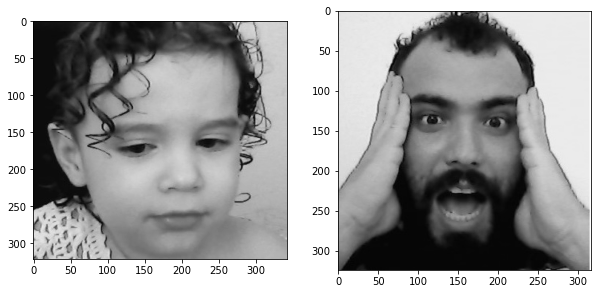

In [ ]:
image1 = cv2.imread('imagens/exemplos/natural1.jpg', cv2.IMREAD_GRAYSCALE)
image2 = cv2.imread('imagens/exemplos/surpreso1.jpg', cv2.IMREAD_GRAYSCALE)


plt.figure(figsize=[10,10])
plt.subplot(1,2,1)
plt.imshow(image1, cmap='gray')

plt.subplot(1,2,2)
plt.imshow(image2, cmap='gray')
plt.show()

In [ ]:
# redimensionando para usar no modelo

image11 = np.expand_dims(np.expand_dims(cv2.resize(image1, (48, 48)), -1), 0)
image21 = np.expand_dims(np.expand_dims(cv2.resize(image2, (48, 48)), -1), 0)

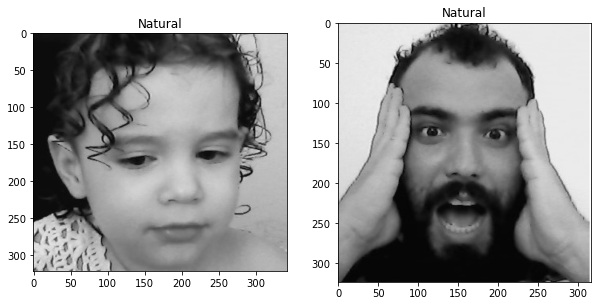

In [ ]:
# fazendo a predição

plt.figure(figsize=[10,8])
plt.subplot(1,2,1)
plt.imshow(image1, cmap='gray')
plt.title(dict_emocoes[np.argmax(modelo_simples.predict(image11))])

plt.subplot(1,2,2)
plt.imshow(image2, cmap='gray')
plt.title(dict_emocoes[np.argmax(modelo_simples.predict(image21))])

plt.show()

## Segunda rede neural.

Vamos criar mais uma rede neural, dessa vez, aumentaremos de maneira significativa a quantidade de camadas e de neurónios, também colocaremos alguma regularizações.

In [ ]:
modelo_avan= Sequential()
modelo_avan.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', 
                 input_shape=(48, 48,1), activity_regularizer=regularizers.l2(1e-5)))
modelo_avan.add(Conv2D(64, kernel_size=(3, 3), padding='same', activation='relu'))
modelo_avan.add(BatchNormalization())
modelo_avan.add(MaxPool2D(pool_size=(2, 2)))
modelo_avan.add(Dropout(0.3))

modelo_avan.add(Conv2D(128, kernel_size=(3, 3), padding='same', 
                       activation='relu', activity_regularizer=regularizers.l2(1e-5)))
modelo_avan.add(MaxPool2D(pool_size=(2, 2)))
modelo_avan.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
modelo_avan.add(BatchNormalization())
modelo_avan.add(MaxPool2D(pool_size=(2, 2)))
modelo_avan.add(Dropout(0.25))

modelo_avan.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu',activity_regularizer=regularizers.l2(1e-5)))
modelo_avan.add(MaxPool2D(pool_size=(2, 2)))
modelo_avan.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
modelo_avan.add(BatchNormalization())
modelo_avan.add(MaxPool2D(pool_size=(2, 2)))
modelo_avan.add(Dropout(0.20))

modelo_avan.add(Flatten()) 
modelo_avan.add(Dense(2048,activation = 'relu'))
modelo_avan.add(Dropout(0.5))
modelo_avan.add(Dense(7,activation = 'softmax'))

modelo_avan.compile(optimizer = 'Adam', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy']
                      )

In [ ]:
modelo_avan.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 48, 48, 64)        18496     
_________________________________________________________________
batch_normalization_4 (Batch (None, 48, 48, 64)        256       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 24, 24, 64)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 24, 24, 128)       73856     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 12, 12, 128)      

In [ ]:
steps_per_epoch = Xtreino.n // Xtreino.batch_size
validation_steps = Xteste.n // Xteste.batch_size

history1 = modelo_avan.fit(x=Xtreino,
                            validation_data=Xteste,
                            epochs=70,
                            callbacks=callbacks,
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=validation_steps,
                            verbose = 1)

Epoch 1/70
410/410 [==============================] - 397s 951ms/step - loss: 18.0954 - accuracy: 0.2653 - val_loss: 2.9995 - val_accuracy: 0.1829
Epoch 2/70
410/410 [==============================] - 383s 934ms/step - loss: 1.7704 - accuracy: 0.3772 - val_loss: 1.6706 - val_accuracy: 0.3883
Epoch 3/70
410/410 [==============================] - 356s 868ms/step - loss: 1.6465 - accuracy: 0.4042 - val_loss: 1.6102 - val_accuracy: 0.4189
Epoch 4/70
410/410 [==============================] - 380s 927ms/step - loss: 1.5582 - accuracy: 0.4310 - val_loss: 1.5183 - val_accuracy: 0.4473
Epoch 5/70
410/410 [==============================] - 345s 842ms/step - loss: 1.5180 - accuracy: 0.4542 - val_loss: 1.4795 - val_accuracy: 0.4612
Epoch 6/70
410/410 [==============================] - 346s 843ms/step - loss: 1.4524 - accuracy: 0.4781 - val_loss: 1.5402 - val_accuracy: 0.4480
Epoch 7/70
410/410 [==============================] - 342s 834ms/step - loss: 1.4167 - accuracy: 0.4863 - val_loss: 1.4141 

In [ ]:
modelo_avan.save('modelos/segundo_modelo.h5')

Conseguimos melhorar um pouco nossa acurácia, porém ainda sim, o valor é baixo.

## Terceira rede neural.

Vamos aumentar ainda mais as quantidade de camadas e neurônios da nossa rede neural.

In [ ]:
modelo_avan2= Sequential()
modelo_avan2.add(Conv2D(32, kernel_size=(3, 3), padding='same', activation='relu', 
                 input_shape=(48, 48,1), activity_regularizer=regularizers.l2(1e-5)))
modelo_avan2.add(Conv2D(256, kernel_size=(3, 3), padding='same', activation='relu'))
modelo_avan2.add(BatchNormalization())

modelo_avan2.add(Conv2D(128, kernel_size=(3, 3), padding='same', 
                       activation='relu', activity_regularizer=regularizers.l2(1e-5)))
modelo_avan2.add(BatchNormalization())
modelo_avan2.add(MaxPool2D(pool_size=(2, 2)))
modelo_avan2.add(Dropout(0.25))

modelo_avan2.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
modelo_avan2.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
modelo_avan2.add(MaxPool2D(pool_size=(2, 2)))
modelo_avan2.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
modelo_avan2.add(BatchNormalization())
modelo_avan2.add(MaxPool2D(pool_size=(2, 2)))
modelo_avan2.add(Dropout(0.20))

modelo_avan2.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
modelo_avan2.add(MaxPool2D(pool_size=(2, 2)))
modelo_avan2.add(Conv2D(128, kernel_size=(3, 3), padding='same', activation='relu'))
modelo_avan2.add(BatchNormalization())
modelo_avan2.add(MaxPool2D(pool_size=(2, 2)))
modelo_avan2.add(Dropout(0.20))


modelo_avan2.add(Flatten()) 
modelo_avan2.add(Dense(256,activation = 'relu'))
modelo_avan2.add(Dense(7,activation = 'softmax'))

modelo_avan2.compile(optimizer = 'Adam', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy']
                      )

In [ ]:
modelo_avan2.summary()

Model: "sequential_25"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_179 (Conv2D)          (None, 48, 48, 32)        320       
_________________________________________________________________
conv2d_180 (Conv2D)          (None, 48, 48, 256)       73984     
_________________________________________________________________
batch_normalization_90 (Batc (None, 48, 48, 256)       1024      
_________________________________________________________________
conv2d_181 (Conv2D)          (None, 48, 48, 128)       295040    
_________________________________________________________________
batch_normalization_91 (Batc (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d_127 (MaxPoolin (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_83 (Dropout)         (None, 24, 24, 128)     

In [ ]:
steps_per_epoch = Xtreino.n // Xtreino.batch_size
validation_steps = Xteste.n // Xteste.batch_size

history1 = modelo_avan2.fit(x=Xtreino,
                            validation_data=Xteste,
                            epochs=70,
                            callbacks=callbacks,
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=validation_steps,
                            verbose = 1)

Epoch 1/70
410/410 [==============================] - 2296s 6s/step - loss: 70.3806 - accuracy: 0.2677 - val_loss: 2.8290 - val_accuracy: 0.1738
Epoch 2/70
410/410 [==============================] - 2288s 6s/step - loss: 1.8124 - accuracy: 0.4033 - val_loss: 1.7173 - val_accuracy: 0.3958
Epoch 3/70
410/410 [==============================] - 2293s 6s/step - loss: 1.5752 - accuracy: 0.4364 - val_loss: 1.5074 - val_accuracy: 0.4563
Epoch 4/70
410/410 [==============================] - 2281s 6s/step - loss: 1.4362 - accuracy: 0.4917 - val_loss: 1.4669 - val_accuracy: 0.4664
Epoch 5/70
410/410 [==============================] - 2277s 6s/step - loss: 1.3576 - accuracy: 0.5111 - val_loss: 1.3990 - val_accuracy: 0.4933
Epoch 6/70
410/410 [==============================] - 2274s 6s/step - loss: 1.2973 - accuracy: 0.5327 - val_loss: 1.3348 - val_accuracy: 0.5176
Epoch 7/70
410/410 [==============================] - 2280s 6s/step - loss: 1.2417 - accuracy: 0.5519 - val_loss: 1.2974 - val_accuracy

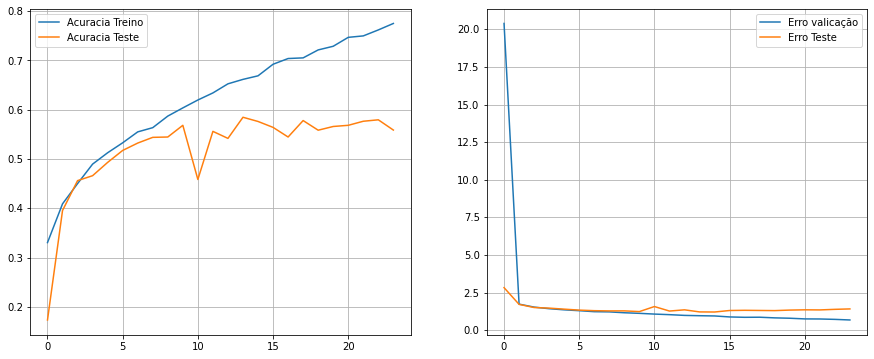

In [ ]:
# analisando graficamente

plt.figure(figsize=[15,6])

plt.subplot(1,2,1)
plt.plot(history1.history['accuracy'], label='Acuracia Treino')
plt.plot(history1.history['val_accuracy'], label='Acuracia Teste')
plt.legend()
plt.grid()

plt.subplot(1,2,2)
plt.plot(history1.history['loss'], label='Erro valicação')
plt.plot(history1.history['val_loss'], label='Erro Teste')
plt.legend()
plt.grid()



plt.show()


In [ ]:
modelo_avan2.save('modelos/terceiro_modelo.h5')

## Quarto modelo.

Iremoas testar mais um modelo, dessa vez, colocaremos algumas regularizações e enxugaremos algumas camadas.

In [ ]:
modelo_avan3= Sequential()
modelo_avan3.add(Conv2D(128, kernel_size=(3, 3), padding='same', input_shape=(48, 48,1),
                       activation='relu', activity_regularizer=regularizers.l2(1e-5),
                       kernel_regularizer=regularizers.l1(1e-5),
                       bias_regularizer=regularizers.l1(1e-5)))
modelo_avan3.add(BatchNormalization())
modelo_avan3.add(MaxPool2D(pool_size=(2, 2)))
modelo_avan3.add(Dropout(0.25))

modelo_avan3.add(Conv2D(128, kernel_size=(3, 3), 
                        padding='same', activation='relu', 
                        activity_regularizer=regularizers.l2(1e-5),
                        kernel_regularizer=regularizers.l1(1e-5)))
modelo_avan3.add(MaxPool2D(pool_size=(2, 2)))

modelo_avan3.add(Conv2D(64, kernel_size=(3, 3), 
                        padding='same', activation='relu', 
                        activity_regularizer=regularizers.l2(1e-5),
                        bias_regularizer=regularizers.l1(1e-5)))
modelo_avan3.add(MaxPool2D(pool_size=(2, 2)))

modelo_avan3.add(Conv2D(64, kernel_size=(3, 3), 
                        padding='same', activation='relu', 
                        activity_regularizer=regularizers.l2(1e-5),
                        bias_regularizer=regularizers.l1(1e-5)))
modelo_avan3.add(MaxPool2D(pool_size=(2, 2)))

modelo_avan3.add(Flatten()) 
modelo_avan3.add(Dense(32,activation = 'relu'))
modelo_avan3.add(Dense(7,activation = 'softmax'))

modelo_avan3.compile(optimizer = 'Adamax', 
                       loss='categorical_crossentropy', 
                       metrics=['accuracy']
                      )

In [ ]:
modelo_avan3.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_214 (Conv2D)          (None, 48, 48, 128)       1280      
_________________________________________________________________
batch_normalization_109 (Bat (None, 48, 48, 128)       512       
_________________________________________________________________
max_pooling2d_154 (MaxPoolin (None, 24, 24, 128)       0         
_________________________________________________________________
dropout_101 (Dropout)        (None, 24, 24, 128)       0         
_________________________________________________________________
conv2d_215 (Conv2D)          (None, 24, 24, 128)       147584    
_________________________________________________________________
max_pooling2d_155 (MaxPoolin (None, 12, 12, 128)       0         
_________________________________________________________________
conv2d_216 (Conv2D)          (None, 12, 12, 64)      

In [ ]:
steps_per_epoch = Xtreino.n // Xtreino.batch_size
validation_steps = Xteste.n // Xteste.batch_size

history2 = modelo_avan3.fit(x=Xtreino,
                            validation_data=Xteste,
                            epochs=70,
                            callbacks=callbacks,
                            steps_per_epoch=steps_per_epoch,
                            validation_steps=validation_steps,
                            verbose = 1)

Epoch 1/70
410/410 [==============================] - 438s 1s/step - loss: 35.5195 - accuracy: 0.2476 - val_loss: 2.4409 - val_accuracy: 0.2490
Epoch 2/70
410/410 [==============================] - 424s 1s/step - loss: 2.1988 - accuracy: 0.3351 - val_loss: 1.8761 - val_accuracy: 0.3668
Epoch 3/70
410/410 [==============================] - 423s 1s/step - loss: 1.7858 - accuracy: 0.4016 - val_loss: 1.6596 - val_accuracy: 0.4336
Epoch 4/70
410/410 [==============================] - 424s 1s/step - loss: 1.6145 - accuracy: 0.4456 - val_loss: 1.5652 - val_accuracy: 0.4640
Epoch 5/70
410/410 [==============================] - 432s 1s/step - loss: 1.5247 - accuracy: 0.4752 - val_loss: 1.5272 - val_accuracy: 0.4573
Epoch 6/70
410/410 [==============================] - 419s 1s/step - loss: 1.4611 - accuracy: 0.4982 - val_loss: 1.4585 - val_accuracy: 0.4886
Epoch 7/70
410/410 [==============================] - 427s 1s/step - loss: 1.3912 - accuracy: 0.5280 - val_loss: 1.4543 - val_accuracy: 0.490

In [ ]:
modelo_avan3.save('modelos/quarto_modelo.h5')

In [13]:
modelo_final = load_model('modelos/terceiro_modelo.h5')

## Escolha do modelo.

Dos quatro modelos treinado, vamos escolhar o terceiro, que terve uma melhor acurácia e um menor erro nos dados de validação.

Vamos testar em algumas imagens, para isso, usaremos mais uma função do OpenCV, uma função que detecta faces em uma imagem.

In [6]:
def gray_photo(image):
    photo  = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    return photo

bounding_box = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')

In [7]:
foto1 = gray_photo('imagens/exemplos/feliz1.jpg')

num_faces = bounding_box.detectMultiScale(foto1,scaleFactor=1.1, minNeighbors=3,minSize= (20,20))

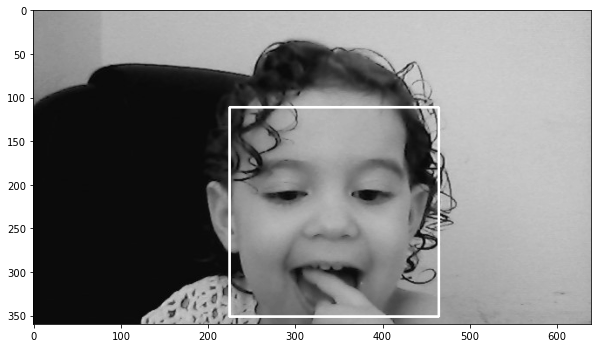

In [8]:
output = foto1.copy()

plt.figure(figsize= [10,10])
for (a, b, w, h) in num_faces:
        cv2.rectangle(output, (a, b), (a + w, b + h), (255, 0, 0), 2)

plt.imshow(output, cmap='gray')
plt.show()    


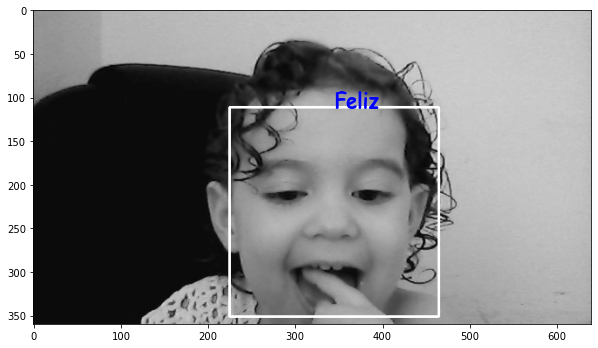

In [14]:
# Aplicando o modelo escolhido no retangulo
csfont = {'fontname':'Comic Sans MS'}

for (a, b, w, h) in num_faces:
    roi = output[b:b + h, a:a + w]
    rei_redi = np.expand_dims(np.expand_dims(cv2.resize(roi, (48, 48)), -1), 0)
        
    plt.figure(figsize=[10,8])
    plt.imshow(output, cmap='gray')
    plt.annotate(xy=(a+w/2,b), 
                 text = dict_emocoes[np.argmax(modelo_final.predict(rei_redi))], 
                 fontsize=20, fontweight='bold', c='blue', **csfont)
    plt.show()

## Criando uma função para detectar emoções

Vamos agora criar uma função, que receb euma imagem, e detecta a emoção de todas as pessoas que estão nela.

In [253]:
def detecta_emocao(image):
    photo1  = cv2.imread(image)
    photo  = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    num_faces = bounding_box.detectMultiScale(photo1,scaleFactor=1.1, minNeighbors=2,minSize= (20,20))
    plt.figure(figsize= [10,10])
    for (a, b, w, h) in num_faces:
        cv2.rectangle(photo, (a, b), (a + w, b + h), (255, 0, 0), 2)
        roi = photo[b:b + h, a:a + w]
        roi_redi = np.expand_dims(np.expand_dims(cv2.resize(roi, (48, 48)), -1), 0)
        plt.annotate(xy=(a+w/2,b),text = dict_emocoes[np.argmax(modelo_final.predict(roi_redi))], 
                     fontsize=15,color = 'crimson', fontweight='bold', **csfont)

    plt.imshow(photo, cmap='gray')
    plt.show()    

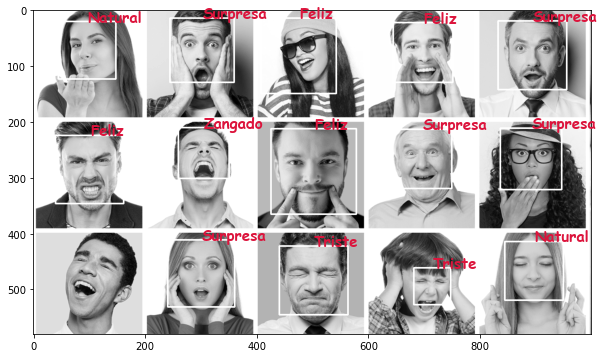

In [254]:
detecta_emocao('imagens/exemplos/emoc.png')

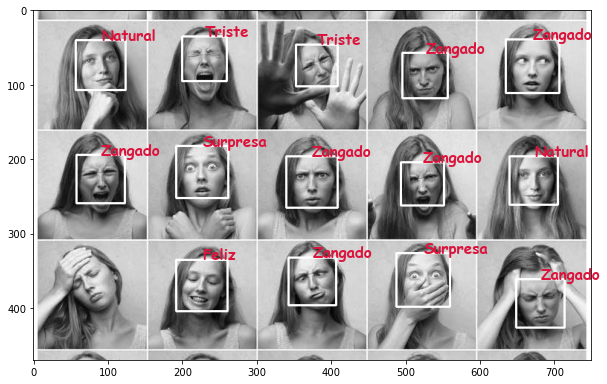

In [255]:
detecta_emocao('imagens/exemplos/foto1.jpg')

Agora criaremos uma função que retorna não apenas a principal emoção, mas todas as emoções em porcentagem.

In [256]:
def detecta_emocao2(image):
    
    photo  = cv2.imread(image, cv2.IMREAD_GRAYSCALE)
    num_faces = bounding_box.detectMultiScale(photo,scaleFactor=1.1, minNeighbors=2,minSize= (20,20))
    plt.figure(figsize= [12,10])
    for (a, b, w, h) in num_faces:
        cv2.rectangle(photo, (a, b), (a + w, b + h), (255, 0, 0), 2)
        roi = photo[b:b + h, a:a + w]
        roi_redi = np.expand_dims(np.expand_dims(cv2.resize(roi, (48, 48)), -1), 0)
        texto = ''
        pred = modelo_final.predict(roi_redi)
        for n in range(len(list(pred[0]))):
            texto += dict_emocoes[n] + ": " + str(round(pred[0][n]*100,2))+'% \n'
        
        plt.annotate(xy=(a+w,b+h),text = texto, 
                     fontsize=10,color = 'crimson', fontweight='bold', **csfont)

    plt.imshow(photo, cmap='gray')
    plt.show()  

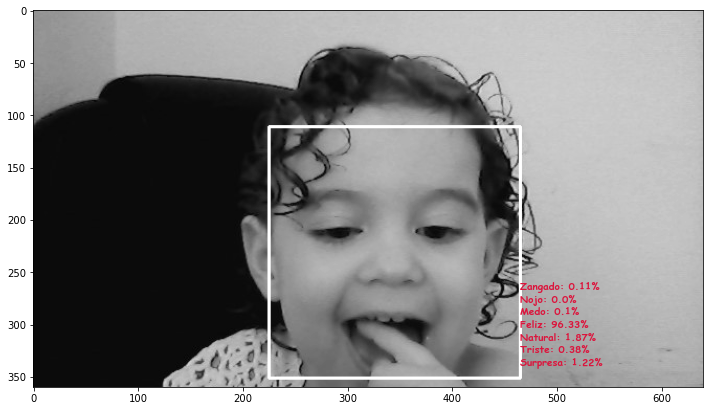

In [257]:
detecta_emocao2('imagens/exemplos/feliz1.jpg')

In [4]:
!pip install Js2Py


  Created wheel for pyjsparser: filename=pyjsparser-2.7.1-py3-none-any.whl size=25998 sha256=36dd32f2c6cc8d19b5c1739e46c8f3977de2ea8c5d7bd1ab9e0c72627d75869c
  Stored in directory: c:\users\luand\appdata\local\pip\cache\wheels\d5\88\34\ccb5bb40eb3178a134eb293e6c363928c5bcfba0b91031db76
Successfully built pyjsparser


In [12]:
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

In [13]:
from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))
  
  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

ReferenceError: takePhoto is not defined
